#### Importing Packages

In [1]:
#Importing the necessary packages
import numpy as np
import pandas as pd
import re
import string
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_union
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

warnings.filterwarnings('ignore')
%matplotlib inline

#### Reading Data

In [2]:
#Reading the data from CSV file
train = pd.read_csv('train.csv').fillna(' ')
test = pd.read_csv('test.csv').fillna(' ')
train.drop(columns = ["id"],inplace = True)
train.shape

(127656, 7)

In [3]:
class_names = ["harsh","extremely_harsh","vulgar","threatening","disrespect","targeted_hate"]

### EDA - Frequency Plot of Labels

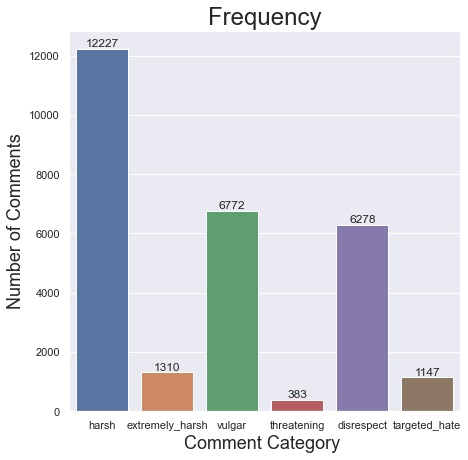

In [4]:
categories = list(train.iloc[:,1:].columns.values)

sns.set(font_scale = 1)
plt.figure(figsize=(7,7))

ax = sns.barplot(categories, train.iloc[:,1:].sum().values)

plt.title("Frequency", fontsize=24)
plt.ylabel('Number of Comments', fontsize=18)
plt.xlabel('Comment Category ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = train.iloc[:,1:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)
plt.show()

## Preprocessing

In [5]:
train_text = train['text']
test_text = test['text']

In [6]:
all_text = pd.concat([train_text,test_text])

In [7]:
#Removing Slang
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text) #multiple spaces 
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"em", " them ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub("[^-9A-Za-z ]", "" , text)
    text = text.strip(' ')  #trimming
    return text

#Removing html elements
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

#Removing punctuation marks
def cleanPunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

#Keeping English Alphabets
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [8]:
all_text = all_text.map(lambda com : clean_text(com))
all_text = all_text.str.lower()
all_text=  all_text.apply(cleanHtml)
all_text = all_text.apply(cleanPunc)
all_text = all_text.apply(keepAlpha)

all_text.head()

0    new main picture how about this for the main p...
1    think of th them like population charts just b...
2    this page se them s a little misleading the re...
3                  actually accounts are never deleted
4    yeah yeah ok so did i still what i meant is we...
Name: text, dtype: object

In [9]:
#Removing Stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

all_text = all_text.apply(removeStopWords)
all_text.head()

0    new main picture      main picture sadly  dont...
1    think  th  like population charts   every year...
2     page se    little misleading  reason   midpoi...
3                     actually accounts  never deleted
4    yeah yeah ok    still   meant   know nothing  ...
Name: text, dtype: object

#### Vectorize using Tfidf

In [10]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    max_features=20000)
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 6),
    max_features=30000)
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=2)

all_text = vectorizer.fit(all_text)
train_features = vectorizer.transform(train_text)
test_features = vectorizer.transform(test_text)

## Approach 1 : SAG solver for Logistic Regression

In [11]:
scores = []
submission = pd.DataFrame.from_dict({'id': test['id']})
for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(solver='sag')

    cv_score = np.mean(cross_val_score(
        classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('Processing : {}.\nTraining accuracy score is {}\n'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1]

print('Overall cross-val score is {}'.format(np.mean(scores)))

submission.to_csv('final_submission.csv', index=False)

Processing : harsh.
Training accuracy score is 0.9750100327535162

Processing : extremely_harsh.
Training accuracy score is 0.9873041714508233

Processing : vulgar.
Training accuracy score is 0.9885556470952938

Processing : threatening.
Training accuracy score is 0.9841569686277266

Processing : disrespect.
Training accuracy score is 0.9810220173130246

Processing : targeted_hate.
Training accuracy score is 0.9797335672491133

Overall cross-val score is 0.9826304007482495


## Approach 2 : Using Ridge classifier with n-grams

In [12]:
scores = []
submission = pd.DataFrame.from_dict({'id': test['id']})
for class_name in class_names:
    train_target = train[class_name]
    classifier = Ridge(alpha=20, copy_X=True, fit_intercept=True, solver='auto',
                        max_iter=100,   normalize=False, random_state=0,  tol=0.0025)
    scores.append(cv_score)
    print('Processing : {}.\nTraining accuracy score is {}\n'.format(class_name, cv_score))
    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict(test_features)
print('Overall cross-val score is {}'.format(np.mean(scores)))

submission.to_csv('ridge.csv', index=False)

Processing : harsh.
Training accuracy score is 0.9797335672491133

Processing : extremely_harsh.
Training accuracy score is 0.9797335672491133

Processing : vulgar.
Training accuracy score is 0.9797335672491133

Processing : threatening.
Training accuracy score is 0.9797335672491133

Processing : disrespect.
Training accuracy score is 0.9797335672491133

Processing : targeted_hate.
Training accuracy score is 0.9797335672491133

Overall cross-val score is 0.9797335672491133


## Approach 3 : Liblinear solver for Logistic Regression simple word vectorizer

In [13]:
train_set, valid_set = train_test_split(train, test_size=0.2, random_state=42)

print(train_set.shape)
print(valid_set.shape)

(102124, 7)
(25532, 7)


In [14]:
vect = TfidfVectorizer(max_features=1000,stop_words='english')

In [15]:
training_X = train_set['text']
training_X_dtm = vect.fit_transform(training_X)

validating_X = valid_set['text']
validating_X_dtm = vect.transform(validating_X)

test_X = test['text']
test_X_dtm = vect.transform(test_X)

In [16]:
logreg = LogisticRegression(C=12.0,solver='liblinear')

submission_binary = pd.read_csv('sample_submission.csv')

for label in class_names:
    print('Processing : {}\n'.format(label))
    training_y = train[:train_set.shape[0]][label]
    validating_y = train[train_set.shape[0]:][label]
    logreg.fit(training_X_dtm, training_y)
    y_pred_validation = logreg.predict(validating_X_dtm)
    print('Training accuracy is {}\n'.format(accuracy_score(validating_y, y_pred_validation)))
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_binary[label] = test_y_prob

Processing : harsh

Training accuracy is 0.9068228105906314

Processing : extremely_harsh

Training accuracy is 0.9909133636221212

Processing : vulgar

Training accuracy is 0.947595174682751

Processing : threatening

Training accuracy is 0.9971016763277456

Processing : disrespect

Training accuracy is 0.9517859940466865

Processing : targeted_hate

Training accuracy is 0.9907958640137866



In [17]:
submission_binary.head()
submission_binary.to_csv('binaryRelevance_liblinear.csv',index=False)